# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [2]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10
matname = 'basics'

In [3]:
from shl_scripts.shl_experiments import SHL
help(SHL)

Help on class SHL in module shl_scripts.shl_experiments:

class SHL(builtins.object)
 |  Base class to define SHL experiments:
 |      - initialization
 |      - coding and learning
 |      - visualization
 |      - quantitative analysis
 |  
 |  Methods defined here:
 |  
 |  __init__(self, height=256, width=256, patch_width=12, patch_ds=8, N_patches=262144, datapath='../database/', name_database='laurent', n_dictionary=529, learning_algorithm='mp', fit_tol=None, do_precision=False, do_mask=True, l0_sparseness=15, one_over_F=True, n_iter=4097, eta=0.005, beta1=0.9, beta2=0.999, epsilon=1e-08, homeo_method='HAP', eta_homeo=0.005, alpha_homeo=0.01, C=4.0, nb_quant=256, P_cum=None, do_sym=False, seed=42, patch_norm=False, batch_size=1024, record_each=128, n_image=None, DEBUG_DOWNSCALE=1, verbose=0, data_cache='data_cache')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  code(self, data, dico, coding_algorithm='mp', matname=None, P_cum=None, fit_tol=None, l

In [4]:
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose)
data = shl.get_data(matname=matname)

Extracting data..No cache found data_cache/basics_data: Extracting data... Extracting data..Photo2018-01-18_0440462510.jpg, Photo2018-01-18_0309392473.jpg, Photo2018-01-18_0343102547.jpg, Photo2018-02-18_0911262631 square.jpg, Photo2018-01-18_0327052545.jpg, Photo2018-01-18_0440352508.jpg, Photo2018-01-18_0230432458.jpg, Photo2018-01-18_0316462527.jpg, Photo2018-01-18_0553172551.jpg, Photo2018-01-18_0423102502.jpg, Photo2018-01-18_0422432500.jpg, Photo2018-01-18_0441022511.jpg, Data is of shape : (262140, 144) - done in 42.43s.
Data is of shape : (262140, 144) - done in 42.61s.


In [5]:
!ls -l {shl.data_cache}/{matname}*

-rw-r--r--  1 laurentperrinet  staff  1109376608 Mar  6 15:47 data_cache/basics_coding.npy
-rw-r--r--  1 laurentperrinet  staff   301985408 Mar  6 16:03 data_cache/basics_data.npy
-rw-r--r--  1 laurentperrinet  staff     2120558 Mar  6 15:38 data_cache/basics_dico.pkl


In [6]:
!rm {shl.data_cache}/{matname}*
!ls -l {shl.data_cache}/{matname}*

ls: data_cache/basics*: No such file or directory


In [7]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.sum(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (262140, 144)
average of patches =  1.4578306989484052e-05  +/-  0.006638689828201611
average energy of data =  0.3557658541625653 +/- 0.45110509243199426


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found data_cache/basics_dico.pkl: Learning the dictionary with algo = mp 
 Training on 262140 patches
Iteration   1 /   4097 (elapsed time:   0s,   0mn   0s)
Iteration  129 /   4097 (elapsed time:  25s,   0mn  25s)
Iteration  257 /   4097 (elapsed time:  52s,   0mn  52s)
Iteration  385 /   4097 (elapsed time:  78s,   1mn  18s)
Iteration  513 /   4097 (elapsed time:  104s,   1mn  44s)
Iteration  641 /   4097 (elapsed time:  130s,   2mn  10s)
Iteration  769 /   4097 (elapsed time:  156s,   2mn  36s)
Iteration  897 /   4097 (elapsed time:  182s,   3mn   2s)
Iteration  1025 /   4097 (elapsed time:  207s,   3mn  27s)
Iteration  1153 /   4097 (elapsed time:  231s,   3mn  51s)
Iteration  1281 /   4097 (elapsed time:  256s,   4mn  16s)
Iteration  1409 /   4097 (elapsed time:  281s,   4mn  41s)
Iteration  1537 /   4097 (elapsed time:  305s,   5mn   5s)
Iteration  1665 /   4097 (elapsed time:  329s,   5mn  29s)
Iteration  1793 /   4097 (elapsed time:  353s,   5mn  53s)
Iteration  1921 /

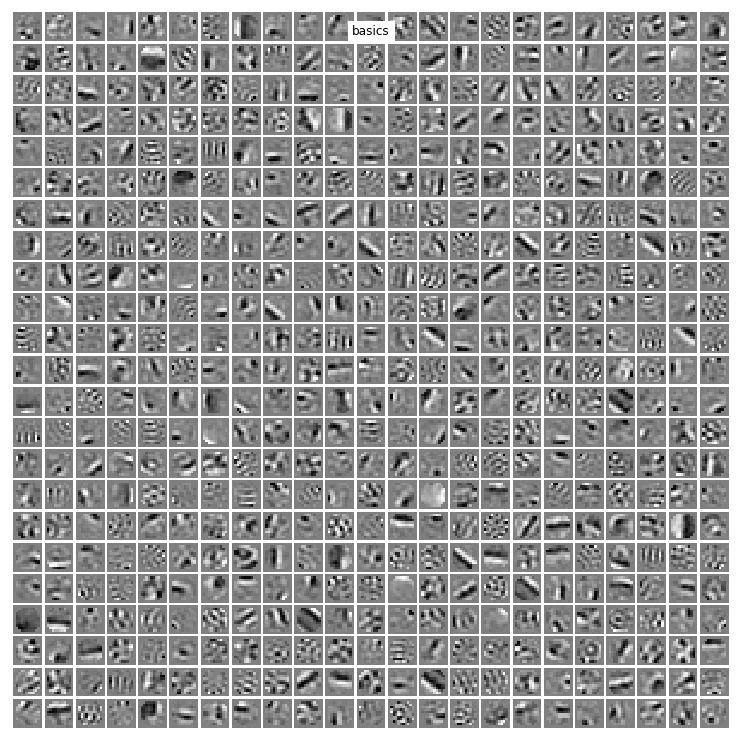

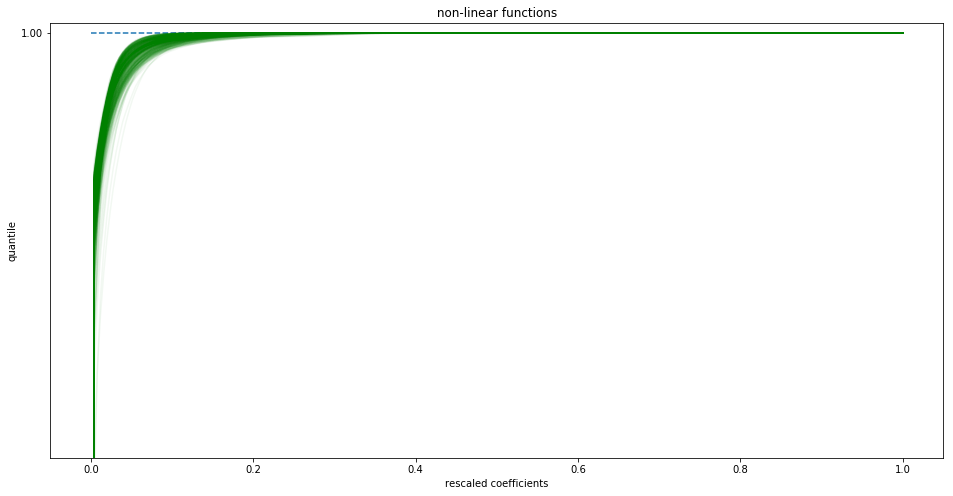

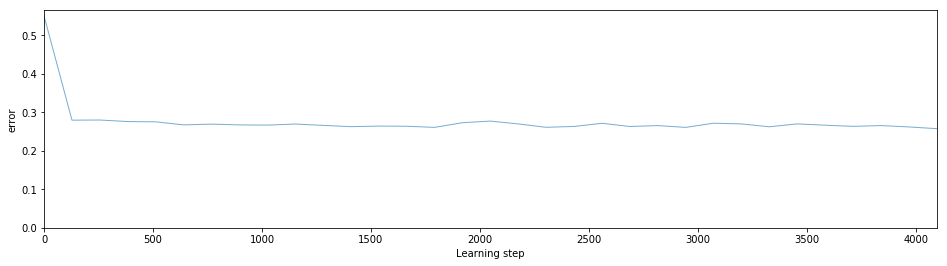

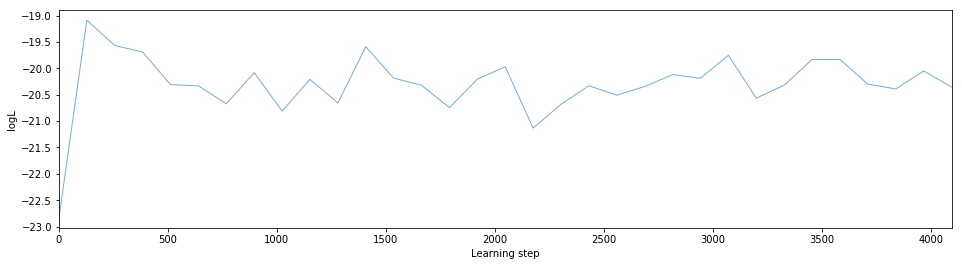

In [8]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL', 'show_Pcum']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']
dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [9]:
help(dico)

Help on SparseHebbianLearning in module shl_scripts.shl_learn object:

class SparseHebbianLearning(builtins.object)
 |  Sparse Hebbian learning
 |  
 |  Finds a dictionary (a set of atoms) that can best be used to represent data
 |  using a sparse code.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_dictionary : int,
 |      Number of dictionary elements to extract
 |  
 |  eta : float or dict
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  n_iter : int,
 |      total number of iterations to perform
 |  
 |  eta_homeo : float
 |      Gives the learning parameter for the homeostatic gain.
 |  
 |  alpha_homeo : float
 |      Gives the smoothing exponent  for the homeostatic gain
 |      If equal to 1 the homeostatic learning rule learns a linear relation to
 |      variance.
 |  
 |  dictionary : array of shape (n_dictionary, n_pixels),
 |      initial value of the dictionary for warm restart scenarios
 |      Use ``None`` for a new learning.
 |  
 |  fit_algorith

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  0.0002190966174144094 +/- 0.010345861296849022
average energy of filters =  1.0 +/- 8.033823353958118e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [11]:
sparse_code = shl.code(data, dico, matname=matname, l0_sparseness=45)
print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('average energy of codewords = ', sparse_code.std(axis=0).mean())
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

No cache found data_cache/basics_coding.npy: Coding with algo = mp 
 Coding data with algorithm  mp number of codes, size of codewords =  (262140, 529)
average of codewords =  0.002835443575268435
average energy of codewords =  0.024132993073017906
std of the average of individual patches =  0.0008006268585443066


In [12]:
patches = sparse_code @ dico.dictionary
print('number of codes, size of reconstructed images = ', patches.shape)

number of codes, size of reconstructed images =  (262140, 144)


In [13]:
error = data - patches
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SE = np.sqrt(np.sum(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())

average of residual patches =  -1.9504121126436147e-05 +/- 0.00023538649939951122
average energy of residual =  0.05235430037367511 +/- 0.06556328206925781


## Version used

In [14]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
Tue Mar 06 16:20:08 2018 CET